
# Estimation, Prediction, and Hypothesis Tests

This notebook mirrors the Week 4 slides and adds runnable examples and visualizations.



## Utilities


In [7]:

import math
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

def with_ax(title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=(6,4))
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    return fig, ax

def beta_pdf(x, a, b):
    from math import lgamma
    x = np.asarray(x)
    out = np.zeros_like(x, dtype=float)
    m = (x>=0) & (x<=1)
    xm = x[m]
    logB = lgamma(a)+lgamma(b)-lgamma(a+b)
    out[m] = np.exp((a-1)*np.log(xm+1e-15) + (b-1)*np.log(1-xm+1e-15) - logB)
    return out

def hdi_interval(samples, prob=0.8):
    # Smallest interval containing 'prob' mass (HDI) for 1D samples.
    x = np.sort(np.asarray(samples))
    n = len(x)
    if n == 0:
        return (np.nan, np.nan)
    m = max(1, int(np.floor(prob * n)))
    widths = x[m:] - x[:n-m]
    j = np.argmin(widths)
    return float(x[j]), float(x[j+m])

def middle_interval(samples, prob=0.8):
    # Central credible interval by quantiles.
    lo = (1-prob)/2
    hi = 1-lo
    x = np.asarray(samples)
    q = np.quantile(x, [lo, hi])
    return float(q[0]), float(q[1])



## Estimation: summarizing posteriors

We'll use the tongue-rolling example from class. Prior $\mathrm{Beta}(\alpha,\beta)$ with $\alpha=\beta=1$ (flat).  
Observed $n=28$ people, with $k=26$ rolling their tongue.

Key summaries:
- **Mean** of $\pi$: $\mathbb{E}[\pi\mid d]$
- **Mode (MAP)**: $\operatorname{argmax}_\pi\, p(\pi\mid d)$ (for Beta posteriors and $\alpha,\beta>1$, the mode is $(\alpha-1)/(\alpha+\beta-2)$ after updating)
- **Variance / standard deviation**
- **Credible intervals**: middle interval vs **highest density interval (HDI)** (we'll compute both from samples)


In [8]:

# Posterior for Beta-Binomial: Beta(alpha+k, beta+n-k)
alpha0, beta0 = 1, 1
n, k = 28, 26
alpha_post, beta_post = alpha0 + k, beta0 + (n - k)
alpha_post, beta_post


(27, 3)

In [9]:

# Summaries by sampling
samps = rng.beta(alpha_post, beta_post, size=100_000)
mean_post = samps.mean()
var_post = samps.var(ddof=1)
sd_post = math.sqrt(var_post)

# MAP (only valid when alpha_post, beta_post > 1)
if alpha_post>1 and beta_post>1:
    map_post = (alpha_post - 1) / (alpha_post + beta_post - 2)
else:
    map_post = np.nan

hdi80 = hdi_interval(samps, 0.80)
hdi95 = hdi_interval(samps, 0.95)
mid80 = middle_interval(samps, 0.80)

mean_post, sd_post, map_post, hdi80, hdi95, mid80


(0.899713219767197,
 0.0538537939972254,
 0.9285714285714286,
 (0.8489856526075209, 0.9753942134777118),
 (0.7940241261748362, 0.9875601421183857),
 (0.826614653111004, 0.9613200648304874))

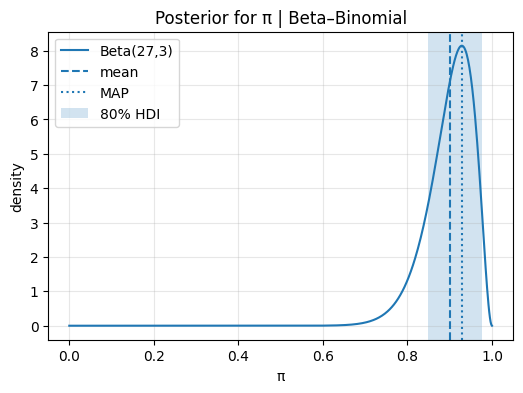

In [10]:

# Visualize posterior density and intervals
xs = np.linspace(0,1,600)
pdf = beta_pdf(xs, alpha_post, beta_post)
pdf /= np.trapz(pdf, xs)

fig, ax = with_ax(title="Posterior for π | Beta–Binomial", xlabel="π", ylabel="density")
ax.plot(xs, pdf, label=f"Beta({alpha_post},{beta_post})")
ax.axvline(mean_post, linestyle="--", label="mean")
if not np.isnan(map_post):
    ax.axvline(map_post, linestyle=":", label="MAP")
ax.axvspan(*hdi80, alpha=0.2, label="80% HDI")
ax.legend(); plt.show()



## Prediction: posterior predictive for counts

Back to tongue rolling: with posterior over $\pi$, predict the number $Y_{\text{new}}$ who can roll their tongue in a new class of size $m=40$.

Two approaches:
- **Analytic Beta–Binomial predictive** (not coded here)
- **Sampling**: draw $\pi^{(i)}\sim p(\pi\mid \text{data})$, then $y^{(i)}\sim \mathrm{Binomial}(m,\pi^{(i)})$


In [11]:

m = 40
pis = rng.beta(alpha_post, beta_post, size=50_000)
y_new = rng.binomial(m, pis)
y_mean = y_new.mean()
y_sd = y_new.std(ddof=1)
y_hdi80 = hdi_interval(y_new, 0.80)
y_hdi95 = hdi_interval(y_new, 0.95)

y_mean, y_sd, y_hdi80, y_hdi95


(35.96896, 2.854995540870558, (33.0, 39.0), (31.0, 40.0))

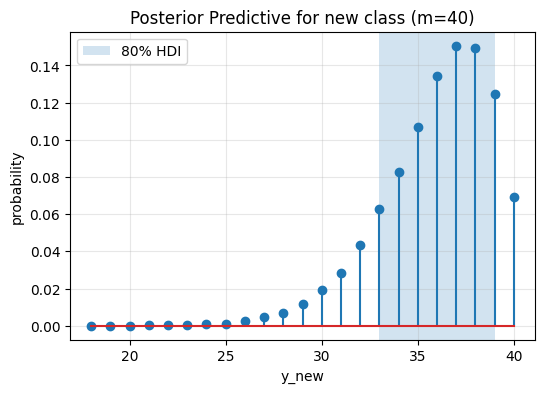

In [12]:

# Visualize posterior predictive
vals, counts = np.unique(y_new, return_counts=True)
pmf = counts / counts.sum()

fig, ax = with_ax(title="Posterior Predictive for new class (m=40)", xlabel="y_new", ylabel="probability")
ax.stem(vals, pmf) #, use_line_collection=True)
ax.axvspan(*y_hdi80, alpha=0.2, label="80% HDI")
ax.legend(); plt.show()



### Decomposing predictive uncertainty

Variance decomposition:
$$
\operatorname{Var}(Y_{\text{new}})=\mathbb{E}[\operatorname{Var}(Y_{\text{new}}\mid \pi)]\;+\;\operatorname{Var}(\mathbb{E}[Y_{\text{new}}\mid \pi]).
$$
- **Aleatoric**: $\mathbb{E}[m\,\pi(1-\pi)]$  
- **Epistemic**: $\operatorname{Var}(m\,\pi)$


In [13]:

aleatoric = np.mean(m * pis * (1 - pis))
epistemic = np.var(m * pis, ddof=1)
total_est = aleatoric + epistemic
empirical = np.var(y_new, ddof=1)
aleatoric, epistemic, total_est, empirical


(3.501436183241799, 4.661498933347135, 8.162935116588933, 8.150999538390769)


## Hypothesis testing: Bayesian versions

We illustrate both one-sided and two-sided tests for the tongue-rolling scenario ($n=28, k=26$).



### One-sided hypothesis: is $\pi > 0.8$?

Posterior probability:
$$
P(\pi>0.8\mid \text{data}) \approx \frac{1}{N}\sum_{i=1}^N \mathbf{1}\{\pi^{(i)}>0.8\}.
$$

For a simple Bayes factor with **truncated uniform** priors:
$$
\text{BF}_{10}=\frac{\int_{0.8}^{1} \pi^k(1-\pi)^{n-k}\, d\pi}{\int_{0}^{0.8} \pi^k(1-\pi)^{n-k}\, d\pi}\cdot\frac{0.8}{0.2}.
$$


In [14]:

p_gt_08 = np.mean(samps > 0.8)

def incomplete_beta_like(a,b, lo, hi, m=20000):
    xs = np.linspace(lo, hi, m)
    f = xs**(a-1) * (1-xs)**(b-1)
    return np.trapz(f, xs)

k, n = 26, 28
num = incomplete_beta_like(k+1, n-k+1, 0.8, 1.0)
den = incomplete_beta_like(k+1, n-k+1, 0.0, 0.8)
BF10 = (num/den) * (1.0/0.2)  # uniform density factor
BF10, p_gt_08


(91.09439503100275, 0.94776)


### Two-sided hypothesis via ROPE

Take $\pi_0=0.93$ and $\delta=0.03$; ROPE $=[0.90, 0.96]$.
Compute posterior mass inside vs outside the ROPE.


In [15]:

pi0, delta = 0.93, 0.03
rope = (pi0-delta, pi0+delta)
p_inside = np.mean((samps >= rope[0]) & (samps <= rope[1]))
p_outside = 1 - p_inside
rope, p_inside, p_outside


((0.9, 0.9600000000000001), 0.45524, 0.54476)


## Practical example: A/B testing on queue lengths

Daily average queue sizes (15 days each):
- Before: $y_b = [13,10,9,5,8,10,9,8,11,9,7,9,9,8,12]$
- After: $y_a = [3,8,8,10,6,5,3,5,2,9,3,10,4,2,8]$

Use a Normal likelihood with **Normal–Inverse-Gamma** prior for each group.


In [16]:

y_b = np.array([13,10,9,5,8,10,9,8,11,9,7,9,9,8,12], dtype=float)
y_a = np.array([3,8,8,10,6,5,3,5,2,9,3,10,4,2,8], dtype=float)

def nig_update(y, m0=10.0, k0=1.0, a0=3.0, b0=18.0):
    n = len(y)
    ybar = y.mean()
    s2 = np.sum((y - ybar)**2)
    kn = k0 + n
    mn = (k0*m0 + n*ybar) / kn
    an = a0 + n/2
    bn = b0 + 0.5*s2 + 0.5*(k0*n/kn)*(ybar - m0)**2
    return mn, kn, an, bn

def sample_nig(mn, kn, an, bn, size=1, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    sigma2 = 1.0 / rng.gamma(shape=an, scale=1.0/bn, size=size)  # InvGamma
    mu = rng.normal(loc=mn, scale=np.sqrt(sigma2/kn), size=size)
    return mu, sigma2

mn_b, kn_b, an_b, bn_b = nig_update(y_b)
mn_a, kn_a, an_a, bn_a = nig_update(y_a)

mu_b, s2_b = sample_nig(mn_b, kn_b, an_b, bn_b, size=50_000, rng=rng)
mu_a, s2_a = sample_nig(mn_a, kn_a, an_a, bn_a, size=50_000, rng=rng)

delta = mu_b - mu_a
delta_mean = delta.mean()
delta_hdi90 = hdi_interval(delta, 0.90)
p_reduction = np.mean(delta > 0)  # positive => before > after

delta_mean, delta_hdi90, p_reduction


(3.1871809149306607, (1.6593628098555513, 4.69291432651692), 0.99954)

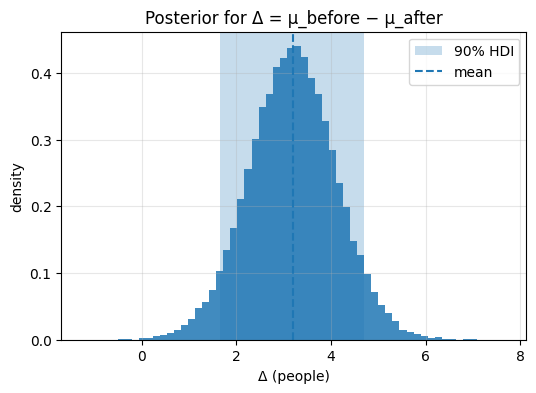

In [17]:

# Visualize the posterior of the difference
fig, ax = with_ax(title="Posterior for Δ = μ_before − μ_after", xlabel="Δ (people)", ylabel="density")
ax.hist(delta, bins=60, density=True, alpha=0.85)
ax.axvspan(*delta_hdi90, alpha=0.25, label="90% HDI")
ax.axvline(delta_mean, linestyle="--", label="mean")
ax.legend(); plt.show()


In [18]:

# Posterior predictive for tomorrow after the feature: y_new ~ N(μ, σ)
y_new_a = rng.normal(mu_a, np.sqrt(s2_a))
pred_mean = y_new_a.mean()
pred_sd = y_new_a.std(ddof=1)
pred_hdi90 = hdi_interval(y_new_a, 0.90)

pred_mean, pred_sd, pred_hdi90


(5.992620674275512,
 3.0761236687852938,
 (1.0711360775809826, 11.15549545845544))

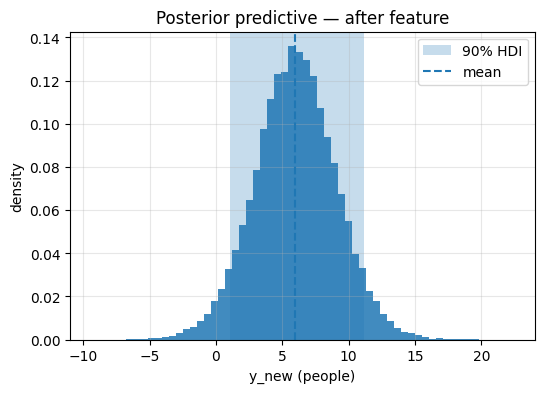

In [19]:

# Visualize predictive
fig, ax = with_ax(title="Posterior predictive — after feature", xlabel="y_new (people)", ylabel="density")
ax.hist(y_new_a, bins=60, density=True, alpha=0.85)
ax.axvspan(*pred_hdi90, alpha=0.25, label="90% HDI")
ax.axvline(pred_mean, linestyle="--", label="mean")
ax.legend(); plt.show()



## Key takeaways
- Summarize posteriors with **mean/MAP/SD** and **credible intervals** (HDI or middle).  
- Posterior predictive integrates over parameter uncertainty; predictive variance decomposes into **aleatoric + epistemic** parts.  
- Bayesian hypothesis tests yield **posterior probabilities** for hypotheses; one-sided via truncated priors and two-sided via **ROPE**.  
- Conjugate **Normal–Inverse-Gamma** makes A/B comparisons and prediction straightforward without external libraries.
